**Random Forest for Feature Selection and Hyperparameter Tuning**

In this project, a **Random Forest** model is used to classify text data.  After training the Random Forest model, **feature importance** is evaluated to select only the most significant features. These features, with an importance score greater than 0.001, are used to train a new Random Forest model. Additionally, **hyperparameters** are optimized using **GridSearch** to improve performance. **Text vectorization techniques** are also applied to prepare the data for machine learning. 

**🔍 More details and comments are available at the end of the file.**

**#0 Imports**

In [1]:
import numpy as np
import pandas as pd
import string
import itertools
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix, roc_curve, roc_auc_score
)

# Disable NLTK warnings
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

**#1 Loading the dataset**

In [2]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])
spam_dataset

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_2916\1996902043.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])


,Spam,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [3]:
print(spam_dataset['Spam'].value_counts(normalize=True))

Spam
0    0.865937
1    0.134063
Name: proportion, dtype: float64


**#2 Removing punctuation**

In [4]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))
spam_dataset

,Spam,Text,Cleaned_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...


**#3 Tokenization**

In [5]:
def tokenize(text):
    # Convert text to lowercase
    clean_text = text.lower()

    # Tokenize
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,..."
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,..."


**#4 Removing stopwords**

In [6]:
stopwords = nltk.corpus.stopwords.words("english")

In [7]:
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b..."


**#5 Stemming**

In [8]:
stemmer = nltk.PorterStemmer()
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Stemmed_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tri, 2, contact, u, u, å£750, poun..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som..."


**#6 Lemmatization**

In [9]:
lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Stemmed_Text,Lemmatized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...","[nah, dont, think, go, usf, life, around, though]"
...,...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tri, 2, contact, u, u, å£750, poun...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]","[pity, mood, soany, suggestion]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som...","[guy, bitching, acted, like, id, interested, b..."


In [10]:
words_spam = list(spam_dataset.loc[spam_dataset['Spam']==1, 'Lemmatized_Text'].values)
words_spam = list(itertools.chain.from_iterable(words_spam))
words_spam = ' '.join(words_spam)
words_notspam = list(spam_dataset.loc[spam_dataset['Spam']==0, 'Lemmatized_Text'].values)
words_notspam = list(itertools.chain.from_iterable(words_notspam))
words_notspam = ' '.join(words_notspam)

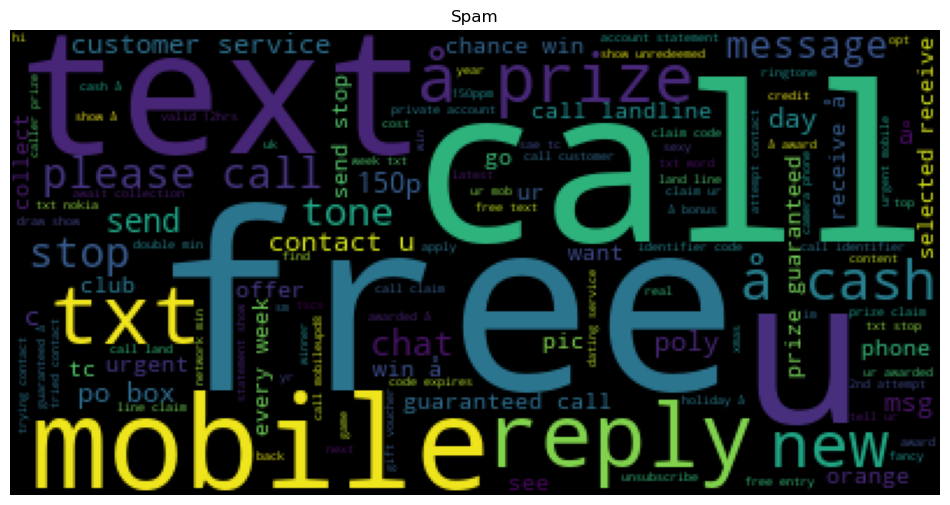

In [11]:
# Word cloud for spam messages

wordcloud = WordCloud().generate(words_spam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Spam')
plt.show()

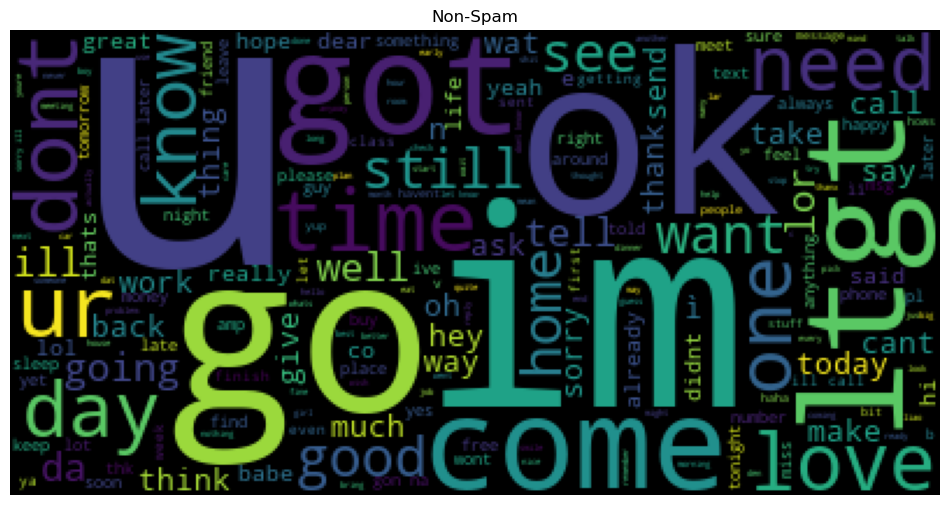

In [12]:
# Word cloud for non-spam messages

wordcloud = WordCloud().generate(words_notspam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Non-Spam')
plt.show()

**#7 Splitting the dataset into training and test sets**

In [13]:
X = spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x))
y = spam_dataset['Spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**#8 Text vectorization (TF-IDF)**

In [14]:
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.5)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

**#9 Training the Random Forest model before feature selection**

In [15]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

**#10 Model evaluation before feature selection**


EVALUATION BEFORE FEATURE SELECTION
Accuracy: 0.9659192825112107
Precision: 0.9172932330827067
Recall: 0.8187919463087249
F1_score: 0.8652482269503546
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.92      0.82      0.87       149

    accuracy                           0.97      1115
   macro avg       0.94      0.90      0.92      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
 [[955  11]
 [ 27 122]]


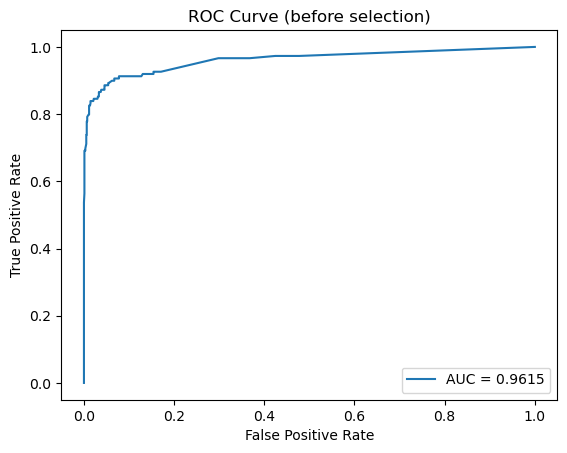

AUC before selection: 0.9615240318479303


In [16]:
y_pred_before = rf_model.predict(X_test_tfidf)

print("\nEVALUATION BEFORE FEATURE SELECTION")
print("Accuracy:", accuracy_score(y_test, y_pred_before))
print("Precision:", precision_score(y_test, y_pred_before))
print("Recall:", recall_score(y_test, y_pred_before))
print("F1_score:", f1_score(y_test, y_pred_before))
print("Classification Report:\n", classification_report(y_test, y_pred_before))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_before))

# ROC curve and AUC before feature selection
y_scores_before = rf_model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores_before)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_scores_before):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (before selection)")
plt.legend()
plt.show()

print("AUC before selection:", roc_auc_score(y_test, y_scores_before))

**#11 Feature importance extraction and selection**

In [17]:
feature_importances = rf_model.feature_importances_
selected_indices = np.where(feature_importances > 0.001)[0]  # Indices of important features
X_train_selected = X_train_tfidf[:, selected_indices]
X_test_selected = X_test_tfidf[:, selected_indices]

# List of selected features
selected_features = np.array(tfidf.get_feature_names_out())[selected_indices]
print(f"\nSelected features ({len(selected_features)}): {selected_features}")


Selected features (92): ['also' 'amp' 'back' 'buy' 'call' 'cant' 'cash' 'claim' 'come' 'contact'
 'customer' 'day' 'dear' 'dont' 'even' 'every' 'find' 'first' 'free'
 'friend' 'get' 'give' 'go' 'going' 'good' 'got' 'great' 'hi' 'home'
 'hope' 'ill' 'im' 'ive' 'know' 'later' 'let' 'like' 'love' 'ltgt' 'make'
 'message' 'min' 'miss' 'mobile' 'money' 'msg' 'na' 'need' 'new' 'next'
 'night' 'number' 'oh' 'ok' 'one' 'per' 'phone' 'pick' 'place' 'please'
 'pls' 'prize' 'reply' 'see' 'send' 'sent' 'service' 'show' 'sorry'
 'still' 'stop' 'take' 'tc' 'tell' 'text' 'thanks' 'think' 'time' 'today'
 'txt' 'ur' 'urgent' 'wan' 'want' 'week' 'win' 'wont' 'work' 'would'
 'year' 'yes' 'youre']


**#12 Hyperparameter optimization for the new model**

In [18]:
param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="f1_macro", n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1_macro')

**#13 Model evaluation after feature selection**

In [19]:
best_rf_model = grid_search.best_estimator_
print("\nBest hyperparameters:", grid_search.best_params_)


Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}



EVALUATION AFTER FEATURE SELECTION
Accuracy: 0.9641255605381166
Precision: 0.9224806201550387
Recall: 0.7986577181208053
F1_score: 0.8561151079136691
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.92      0.80      0.86       149

    accuracy                           0.96      1115
   macro avg       0.95      0.89      0.92      1115
weighted avg       0.96      0.96      0.96      1115

Confusion Matrix:
 [[956  10]
 [ 30 119]]


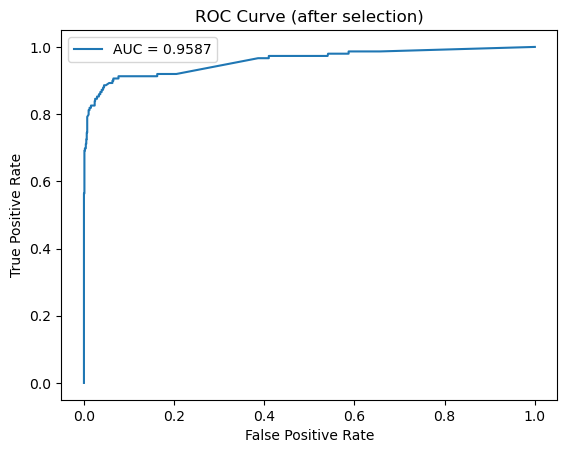

AUC after selection: 0.9587449803382107


In [20]:
y_pred_after = best_rf_model.predict(X_test_selected)

print("\nEVALUATION AFTER FEATURE SELECTION")
print("Accuracy:", accuracy_score(y_test, y_pred_after))
print("Precision:", precision_score(y_test, y_pred_after))
print("Recall:", recall_score(y_test, y_pred_after))
print("F1_score:", f1_score(y_test, y_pred_after))
print("Classification Report:\n", classification_report(y_test, y_pred_after))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_after))

# ROC curve and AUC after feature selection
y_scores_after = best_rf_model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores_after)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_scores_after):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (after selection)")
plt.legend()
plt.show()

print("AUC after selection:", roc_auc_score(y_test, y_scores_after))

**#14 Final Report**

In [21]:
# Metrics before feature selection
metrics_before = {
    "Accuracy": accuracy_score(y_test, y_pred_before),
    "Precision": precision_score(y_test, y_pred_before),
    "Recall": recall_score(y_test, y_pred_before),
    "F1-score": f1_score(y_test, y_pred_before),
    "AUC": roc_auc_score(y_test, y_scores_before)
}

# Metrics after feature selection
metrics_after = {
    "Accuracy": accuracy_score(y_test, y_pred_after),
    "Precision": precision_score(y_test, y_pred_after),
    "Recall": recall_score(y_test, y_pred_after),
    "F1-score": f1_score(y_test, y_pred_after),
    "AUC": roc_auc_score(y_test, y_scores_after)
}

# Creating DataFrame for comparison
comparison_df = pd.DataFrame([metrics_before, metrics_after], index=["Before selection", "After selection"])

# Displaying the table
print(comparison_df)

                  Accuracy  Precision    Recall  F1-score       AUC
Before selection  0.965919   0.917293  0.818792  0.865248  0.961524
After selection   0.964126   0.922481  0.798658  0.856115  0.958745


**#15 Summary**

After feature selection, the model retained very similar prediction quality.

• **Accuracy** decreased slightly from **96.59%** to **96.41%**, and **Recall** dropped from **81.88% to 79.87%**. **F1-score** also decreased from **86.52%** to **85.61%**. **AUC** also slightly dropped.
• **Precision** increased from **91.73%** to **92.25%**, indicating that the model misclassifies fewer negative examples as positive.

In conclusion, **feature selection simplified the model with minimal loss in performance.**